In [1]:
## Import packages
import datetime
import numpy as np
import glob
import echopype as ep
from echopype import open_raw
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import os
from os import path

### Import glider azfp files, add glider info and merge data

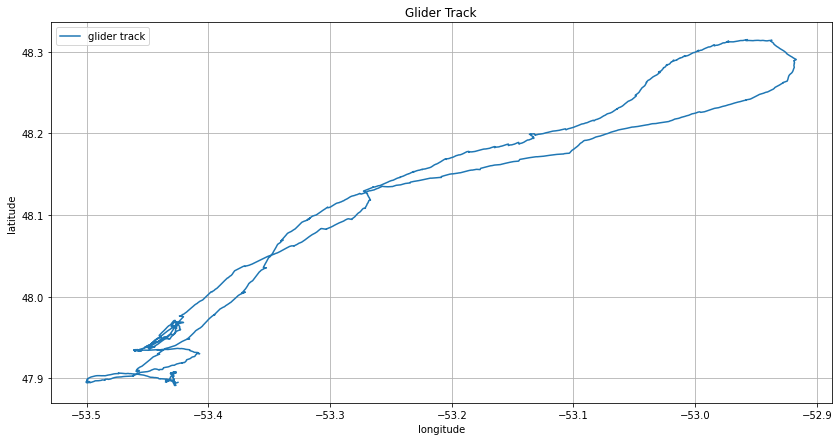

In [2]:
glider_data = '/Users/research/Desktop/AZFP_GLIDER_PROJECT/barnacle_20221120_deployment/nc_files/barnacle_trinity_bay_mission_L1.nc'
gl = xr.open_dataset(glider_data,decode_times=False)

fig, ax = plt.subplots(figsize=(14.0, 7.0))
ax.plot(gl['lon'],gl['lat'],label='glider track')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Glider Track')
ax.grid()
ax.legend()
fig.savefig("GliderTrack.png")
plt.show()


In [3]:
# CONVERT AZFP FILES
#savedir =  '/Users/research/Desktop/AZFP_GLIDER_PROJECT/barnacle_20221120_deployment/AZFP_files_202211/nc/'

azfp_file_path = '/Users/research/Desktop/AZFP_GLIDER_PROJECT/barnacle_20221120_deployment/AZFP_files_202211'
xml_file_path = '/Users/research/Desktop/AZFP/FakeAZFP.xml'    
fnames = sorted(glob.glob(azfp_file_path + '/22112122.01A'))


for fn in fnames:
    if os.stat(fn).st_size !=0:
        print('convert ' + fn)    
        print(xml_file_path,fn)
        ed = open_raw(fn, sonar_model='AZFP', xml_path=xml_file_path)
        print(ed)
        #ed.to_netcdf(save_path=savedir) # Commented out, but used to save the "ed" sonar file info into netcdf
 
# Grab Netcdf data  
#filenames = sorted(glob.glob(savedir + '/*.nc'))[35] # picking a random file in the list
#print(filenames)
#nf = Dataset(filenames, mode='r')
#bsc=nf.groups['Sonar'].groups['Beam_group1'].variables['backscatter_r']
#bsc.shape

#bsc_67 = bsc[0,:,:,0]  # 67.5 kHz channel
#bsc_120 = bsc[1,:,:,0] # 120 kHz Channel
#bsc_200 = bsc[2,:,:,0] # 200 kHz Channel
#bsc_455 = bsc[3,:,:,0] # 455 kHz Channel 
#fig1 = plt.figure(figsize=(10.0, 7.0))
#ax = plt.gca()
#ax.pcolor(bsc_455.transpose())
#ax.set_ylim([0, 2000])
#ax.invert_yaxis()
#fig1.savefig("Backscatter455_Check.png")

convert /Users/research/Desktop/AZFP_GLIDER_PROJECT/barnacle_20221120_deployment/AZFP_files_202211/22112122.01A
/Users/research/Desktop/AZFP/FakeAZFP.xml /Users/research/Desktop/AZFP_GLIDER_PROJECT/barnacle_20221120_deployment/AZFP_files_202211/22112122.01A
<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter data (either complex samples or uncalibrated power samples) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.


azfp file ping= 1669068331 glider time= 1668946133.296
[131653 131654 131655 ... 135531 135532 135533]


/Users/research/opt/anaconda3/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


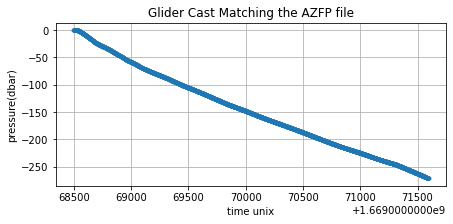

In [4]:
# Figure out the glider data that pertains to the AZFP file record
# Changing the xarray time to unix to index with the glider data
azfp_time = ed.beam.ping_time.data.astype('datetime64[s]').astype('uint32')
glider_time = gl.time_unix.data

# See the unix time stamps
print('azfp file ping=',azfp_time[0],'glider time=',glider_time[0])

# we can now querry the glider data
gl_idx = np.argwhere(np.logical_and(glider_time>=azfp_time[0], glider_time<=azfp_time[-1])).flatten()
print(gl_idx)
# AZFP co-located T, S, P data from the glider
T = (gl.temperature.data)[gl_idx]
S = (gl.salinity.data)[gl_idx]
P = (gl.pressure.data)[gl_idx]
glider_time = glider_time[gl_idx]



# Great it matches - we go a downcast which is the only time we used the AZFP! 
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(glider_time[:], -P[:],'.')
ax.set(xlabel='time unix', ylabel='pressure(dbar)', title='Glider Cast Matching the AZFP file')
ax.grid()
fig.savefig("GliderCastSegment.png")
plt.show()

In [5]:
# now need to use the echopype function to calibrate the backscatter group values in the "ed" object
env_params = {
    'temperature': np.nanmean(T),   # temperature in degree Celsius
    'salinity': np.nanmean(S),     # salinity in PSU
    'pressure': np.nanmean(P),     # pressure in dbar
}

ds_Sv = ep.calibrate.compute_Sv(ed, env_params=env_params)
ds_Sv

<xarray.Dataset>
Dimensions:                (channel: 4, ping_time: 654, range_sample: 8320,
                            filenames: 1)
Coordinates:
  * channel                (channel) <U11 '59023-67-1' ... '59023-455-4'
  * ping_time              (ping_time) datetime64[ns] 2022-11-21T22:05:31 ......
  * range_sample           (range_sample) int64 0 1 2 3 ... 8316 8317 8318 8319
  * filenames              (filenames) int64 0
Data variables: (12/16)
    Sv                     (channel, ping_time, range_sample) float64 -78.64 ...
    echo_range             (channel, ping_time, range_sample) float64 0.182 ....
    frequency_nominal      (channel) float64 6.7e+04 1.2e+05 2e+05 4.55e+05
    temperature            float64 1.607
    salinity               float64 32.65
    pressure               float64 150.7
    ...                     ...
    TVR                    (channel) float64 158.9 167.8 165.2 168.7
    VTX                    (channel) float64 136.1 163.7 160.9 116.7
    equivalent_beam_angle  (channel, ping_time) float64 0.05415 ... 0.01356
    Sv_offset              (channel) float64 0.8 0.8 0.8 0.8
    source_filenames       (filenames) <U103 '/Users/research/Desktop/AZFP_GL...
    water_level            float64 nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.3
    processing_time:              2023-03-02T12:25:36Z
    processing_function:          calibrate.compute_Sv

In [6]:
# Interpolate glider time series to  ping time series
idx = np.argwhere(  np.unique(   P[~np.isnan(P)]   )   ).flatten()

P_azfp=np.interp(azfp_time,glider_time[idx],P[idx])
P_azfp[np.isnan(P_azfp)]=0
#print(P_azfp)


(8320, 654) (8320, 654) (654, 8320)


/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_12506/845801685.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh=ax.pcolormesh(x,-y,SV_64kHz.transpose())


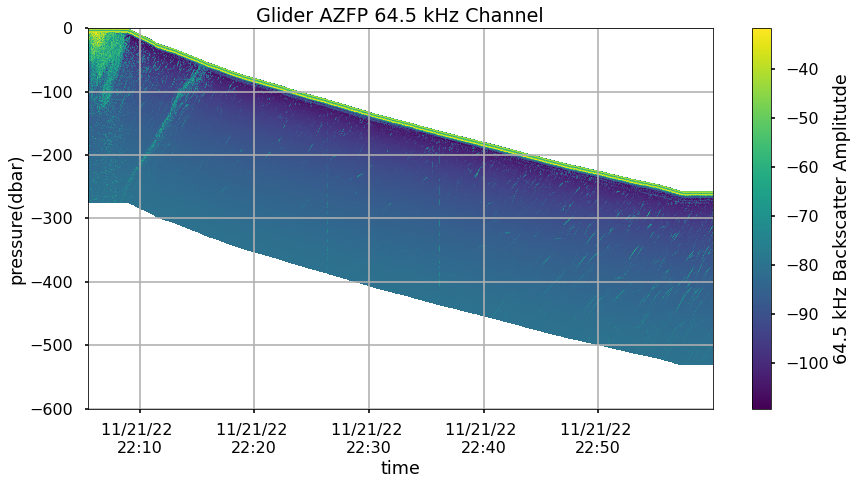

In [9]:
# Lets check the output
[x,y]=np.meshgrid(ds_Sv.ping_time,ds_Sv.range_sample)
[bb,by]=np.meshgrid(P_azfp,ds_Sv.range_sample)
y = bb+by/10

from datetime import datetime
import time
import matplotlib.dates as mdates



echo_range = ds_Sv.echo_range[0,:,:]
SV_64kHz=ds_Sv.Sv[0,:,:] # 64.5 kHz

print(x.shape,y.shape,SV_64kHz.shape)

plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


f = plt.figure(figsize=(14,7))
ax = f.add_subplot(111)
mesh=ax.pcolormesh(x,-y,SV_64kHz.transpose())
ax.set(xlabel='time', ylabel='pressure(dbar)', title='Glider AZFP 64.5 kHz Channel',ylim=[-600, 0])
ax.grid()
ax.xaxis.set_major_formatter(myFmtlong)
plt.colorbar(mesh, ax=ax,label="64.5 kHz Backscatter Amplitutde")
f.savefig("GliderAZFP_Segment.png")
plt.show()

There is a lot more context provided here: https://echopype.readthedocs.io/en/stable/process.html